In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

In [2]:
class Recording:
    # Data paths
    root = 'C:/Users/annej/OneDrive/Documents/GitHub/MASTER-eeg-stress-det'
    dir_raw = root + '/Data/ICA_data'
    dir_filtered = root + '/Data/ICA_data_2'
    
    # Parameters
    Fs = 250
    ch_type = 'eeg'
    n_channels = 8
    
    def __init__(self, sub_nr, ses_nr, run_nr):
        self.sub_nr = sub_nr
        self.ses_nr = ses_nr
        self.run_nr = run_nr
        
        # Load data
        self.load_data()
                
        # Create mne RawArray
        info = mne.create_info(8, sfreq=self.Fs, ch_types=self.ch_type, verbose=None)
        #print(info)
        #self.raw_arr = mne.io.RawArray(self.data*1e-6, info, first_samp = 0, copy = 'auto', verbose = None)
        self.raw_arr = mne.io.RawArray(self.data*1e-6, info)

        mapping = {'0':'F4','1':'Fp2','2':'C3','3':'FC6','4':'O1','5':'Oz','6':'FT9','7':'T8'}
        mne.rename_channels(self.raw_arr.info, mapping)

        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.raw_arr.set_montage(montage)    
    #----------------------------------------------------------------------------------------------------
    
    def load_data(self):
        dir = self.dir_raw
        data_key = 'Clean_data'
        # Load one recording
        filename = f"/sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}.mat"
        f = dir + filename
        self.data = scipy.io.loadmat(f)[data_key]
        print(self.data.shape)
        print(self.data)

    def save_data(self):
        title = f"sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1e6)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.root}/Data/ICA_data_2/{title}.mat', clean_dict)
        
    def init_filter(self):
        band_pass = self.raw_arr.copy().filter(1, 50)
        sav_gol = band_pass.copy().savgol_filter(h_freq=10, verbose=False)
        return sav_gol

    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=8, max_iter=10000, random_state=97)
        self.ica.fit(self.raw_arr)
        
    def plot_sources(self):
        print(self.raw_arr[1])
        print(self.raw_arr[2])
        self.ica.plot_sources(self.raw_arr, title=f'ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, ch_type = self.ch_type , reject='auto')

    def plot_properties(self, components):
        self.ica.plot_properties(self.raw_arr, picks = components)
        
    def test_exclude(self, components):
        print(self.raw_arr[1][0])
        print(self.raw_arr[2])
        self.ica.plot_overlay(self.raw_arr, exclude=components, picks='eeg', show = True)
        print(self.raw_arr[1])
        print(self.raw_arr[2])

    #def test_exclude(self, components):
    #    self.ica.plot_overlay(self.raw_arr, exclude=components, picks='eeg', start = 0., stop = 300., show = True)

    def exclude_ICA(self, components):
        self.ica.exclude = components
        print(self.ica.exclude)
        self.reconst_arr = self.raw_arr.copy()
        self.ica.apply(self.reconst_arr)
    
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                fig = self.ica.plot_sources(self.raw_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=None, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    #scalings = 18 is good
                    fig = data.plot(duration = 600, title=f'{title}', n_channels=4, scalings=None, show_scrollbars=False)
                    fig.savefig(f'{self.root}/Figures/{title}.png') 



In [3]:
test = Recording(sub_nr="P016", ses_nr="S001", run_nr="001")

(8, 75168)
[[ 0.37093397 -4.11446788 -6.24328823 ...  0.52293331  0.41846674
   0.05568144]
 [ 1.76008688  3.22264224  4.2238752  ... -5.77702267 -4.6449117
  -2.60199401]
 [ 0.54389305 -3.16358846 -4.90855832 ...  6.90423167  6.35388454
   1.60998736]
 ...
 [-6.76868394  3.54079498  7.70299205 ...  3.70642402  2.68266336
  -0.86996954]
 [ 1.68941206 -0.47695005 -1.2906384  ... -1.26201236 -0.81601618
  -0.60061692]
 [ 1.01781705  8.98297715 13.01842075 ... -4.32488845 -3.40995461
  -1.42097638]]
Creating RawArray with float64 data, n_channels=8, n_times=75168
    Range : 0 ... 75167 =      0.000 ...   300.668 secs
Ready.


In [4]:
test.plot('raw')

Using qt as 2D backend.


Channels marked as bad:
none


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


C:\Users\annej\AppData\Local\Temp\ipykernel_38128\1712753689.py:61: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  self.ica.fit(self.raw_arr)


Fitting ICA took 0.4s.
(array([[ 1.76008688e-06,  3.22264224e-06,  4.22387520e-06, ...,
        -5.77702267e-06, -4.64491170e-06, -2.60199401e-06]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.00660e+02,
       3.00664e+02, 3.00668e+02]))
(array([[ 5.43893046e-07, -3.16358846e-06, -4.90855832e-06, ...,
         6.90423167e-06,  6.35388454e-06,  1.60998736e-06]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.00660e+02,
       3.00664e+02, 3.00668e+02]))
Creating RawArray with float64 data, n_channels=8, n_times=75168
    Range : 0 ... 75167 =      0.000 ...   300.668 secs
Ready.


C:\Users\annej\AppData\Local\Temp\ipykernel_38128\1712753689.py:61: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.7) and smallest (1.4e-32) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 4
  self.ica.fit(self.raw_arr)


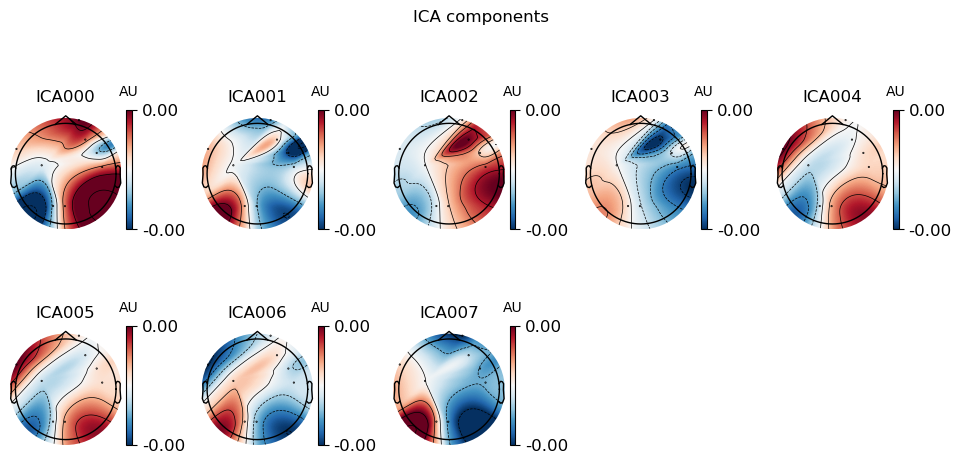

In [6]:
test.init_ICA()
test.plot_sources()

In [ ]:
#test.plot_properties([0,7])

[[ 1.76008688e-06  3.22264224e-06  4.22387520e-06 ... -5.77702267e-06
  -4.64491170e-06 -2.60199401e-06]]
(array([[ 5.43893046e-07, -3.16358846e-06, -4.90855832e-06, ...,
         6.90423167e-06,  6.35388454e-06,  1.60998736e-06]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.00660e+02,
       3.00664e+02, 3.00668e+02]))
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


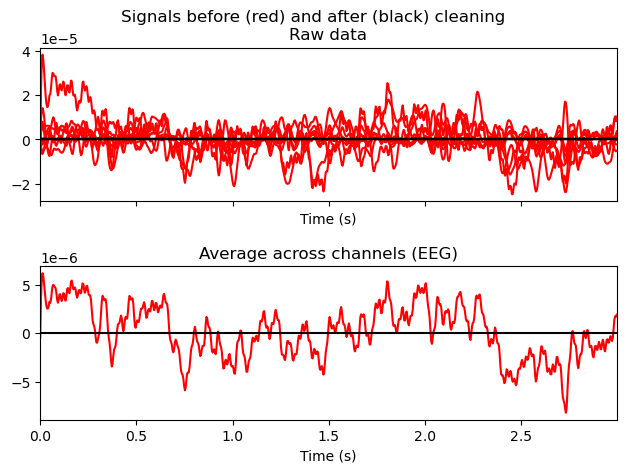

(array([[ 1.76008688e-06,  3.22264224e-06,  4.22387520e-06, ...,
        -5.77702267e-06, -4.64491170e-06, -2.60199401e-06]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.00660e+02,
       3.00664e+02, 3.00668e+02]))
(array([[ 5.43893046e-07, -3.16358846e-06, -4.90855832e-06, ...,
         6.90423167e-06,  6.35388454e-06,  1.60998736e-06]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 3.00660e+02,
       3.00664e+02, 3.00668e+02]))


In [8]:
test.test_exclude([1])

In [9]:
test.exclude_ICA([0])
test.plot('raw')
test.plot('reconstructed')



[0]
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
#test.plot('raw', save=True)
#test.plot('filtered', save=True)
#test.plot('ica', save=True)
#test.plot('reconstructed', save=True)

In [ ]:
test.save_data()